In [8]:
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.metrics import f1_score
from sklearn import tree

## Load data

In [9]:
#reading wdbc
with open('wdbc.pkl', 'rb') as f:
    data = pickle.load(f)

df = data.drop(["id"], axis=1)
df = df.drop(df.iloc[:, 11:], axis=1)
df

,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,symmetry_0,fractal dimension_0
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016


## Data exploration

Malignent: 62.741652021089635
Benign: 37.258347978910365


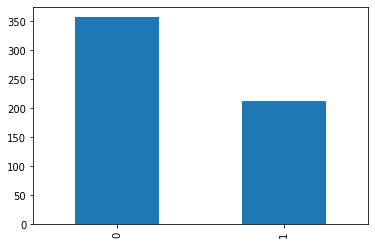

In [10]:
df["malignant"].value_counts().plot(kind="bar")
label_cnts = df["malignant"].value_counts()
cnt_malig, cnt_benign = label_cnts[0], label_cnts[1]
print(f"Malignent: {(cnt_malig / label_cnts.sum()) * 100}")
print(f"Benign: {(cnt_benign / label_cnts.sum()) * 100}")

In [11]:
# Check for missingness
print(df.apply(lambda x: sum(x.isnull()), axis=0))

malignant              0
radius_0               0
texture_0              0
perimeter_0            0
area_0                 0
smoothness_0           0
compactness_0          0
concavity_0            0
concave points_0       0
symmetry_0             0
fractal dimension_0    0
dtype: int64


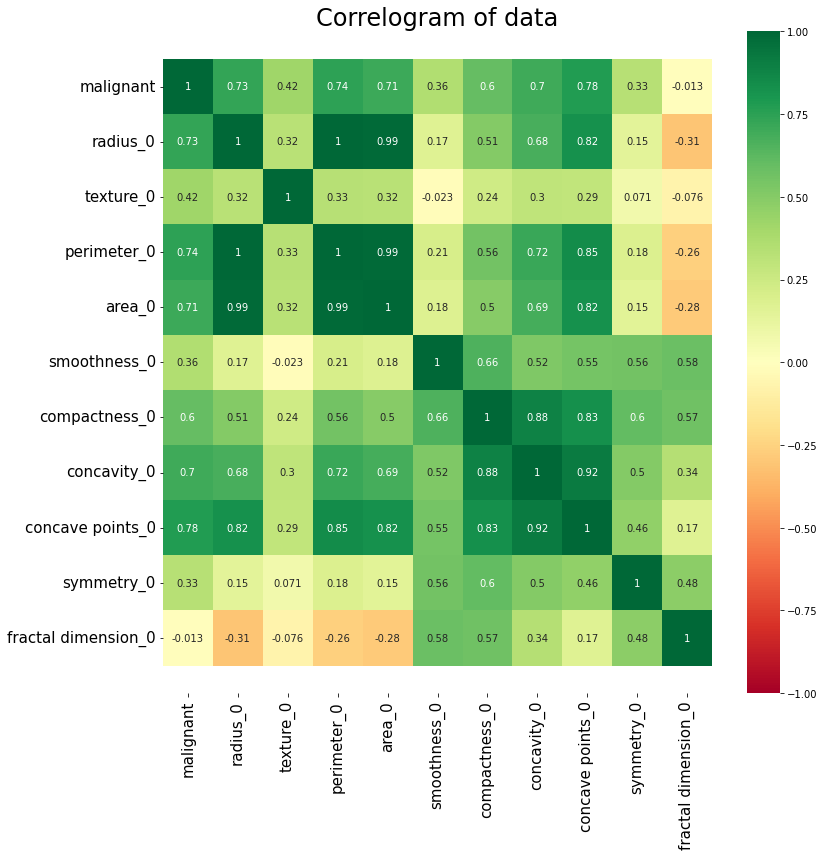

In [20]:
# show correlation between features

plt.figure(figsize=(12, 12))
ax = sns.heatmap(df.corr(), 
                 xticklabels=df.corr().columns, 
                 yticklabels=df.corr().columns, 
                 cmap='RdYlGn', 
                 center=0, 
                 annot=True,
                 vmin=-1,
                 vmax= 1)

plt.title('Correlogram of data', fontsize=24)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("correlogram.png")
plt.show()
plt.close()

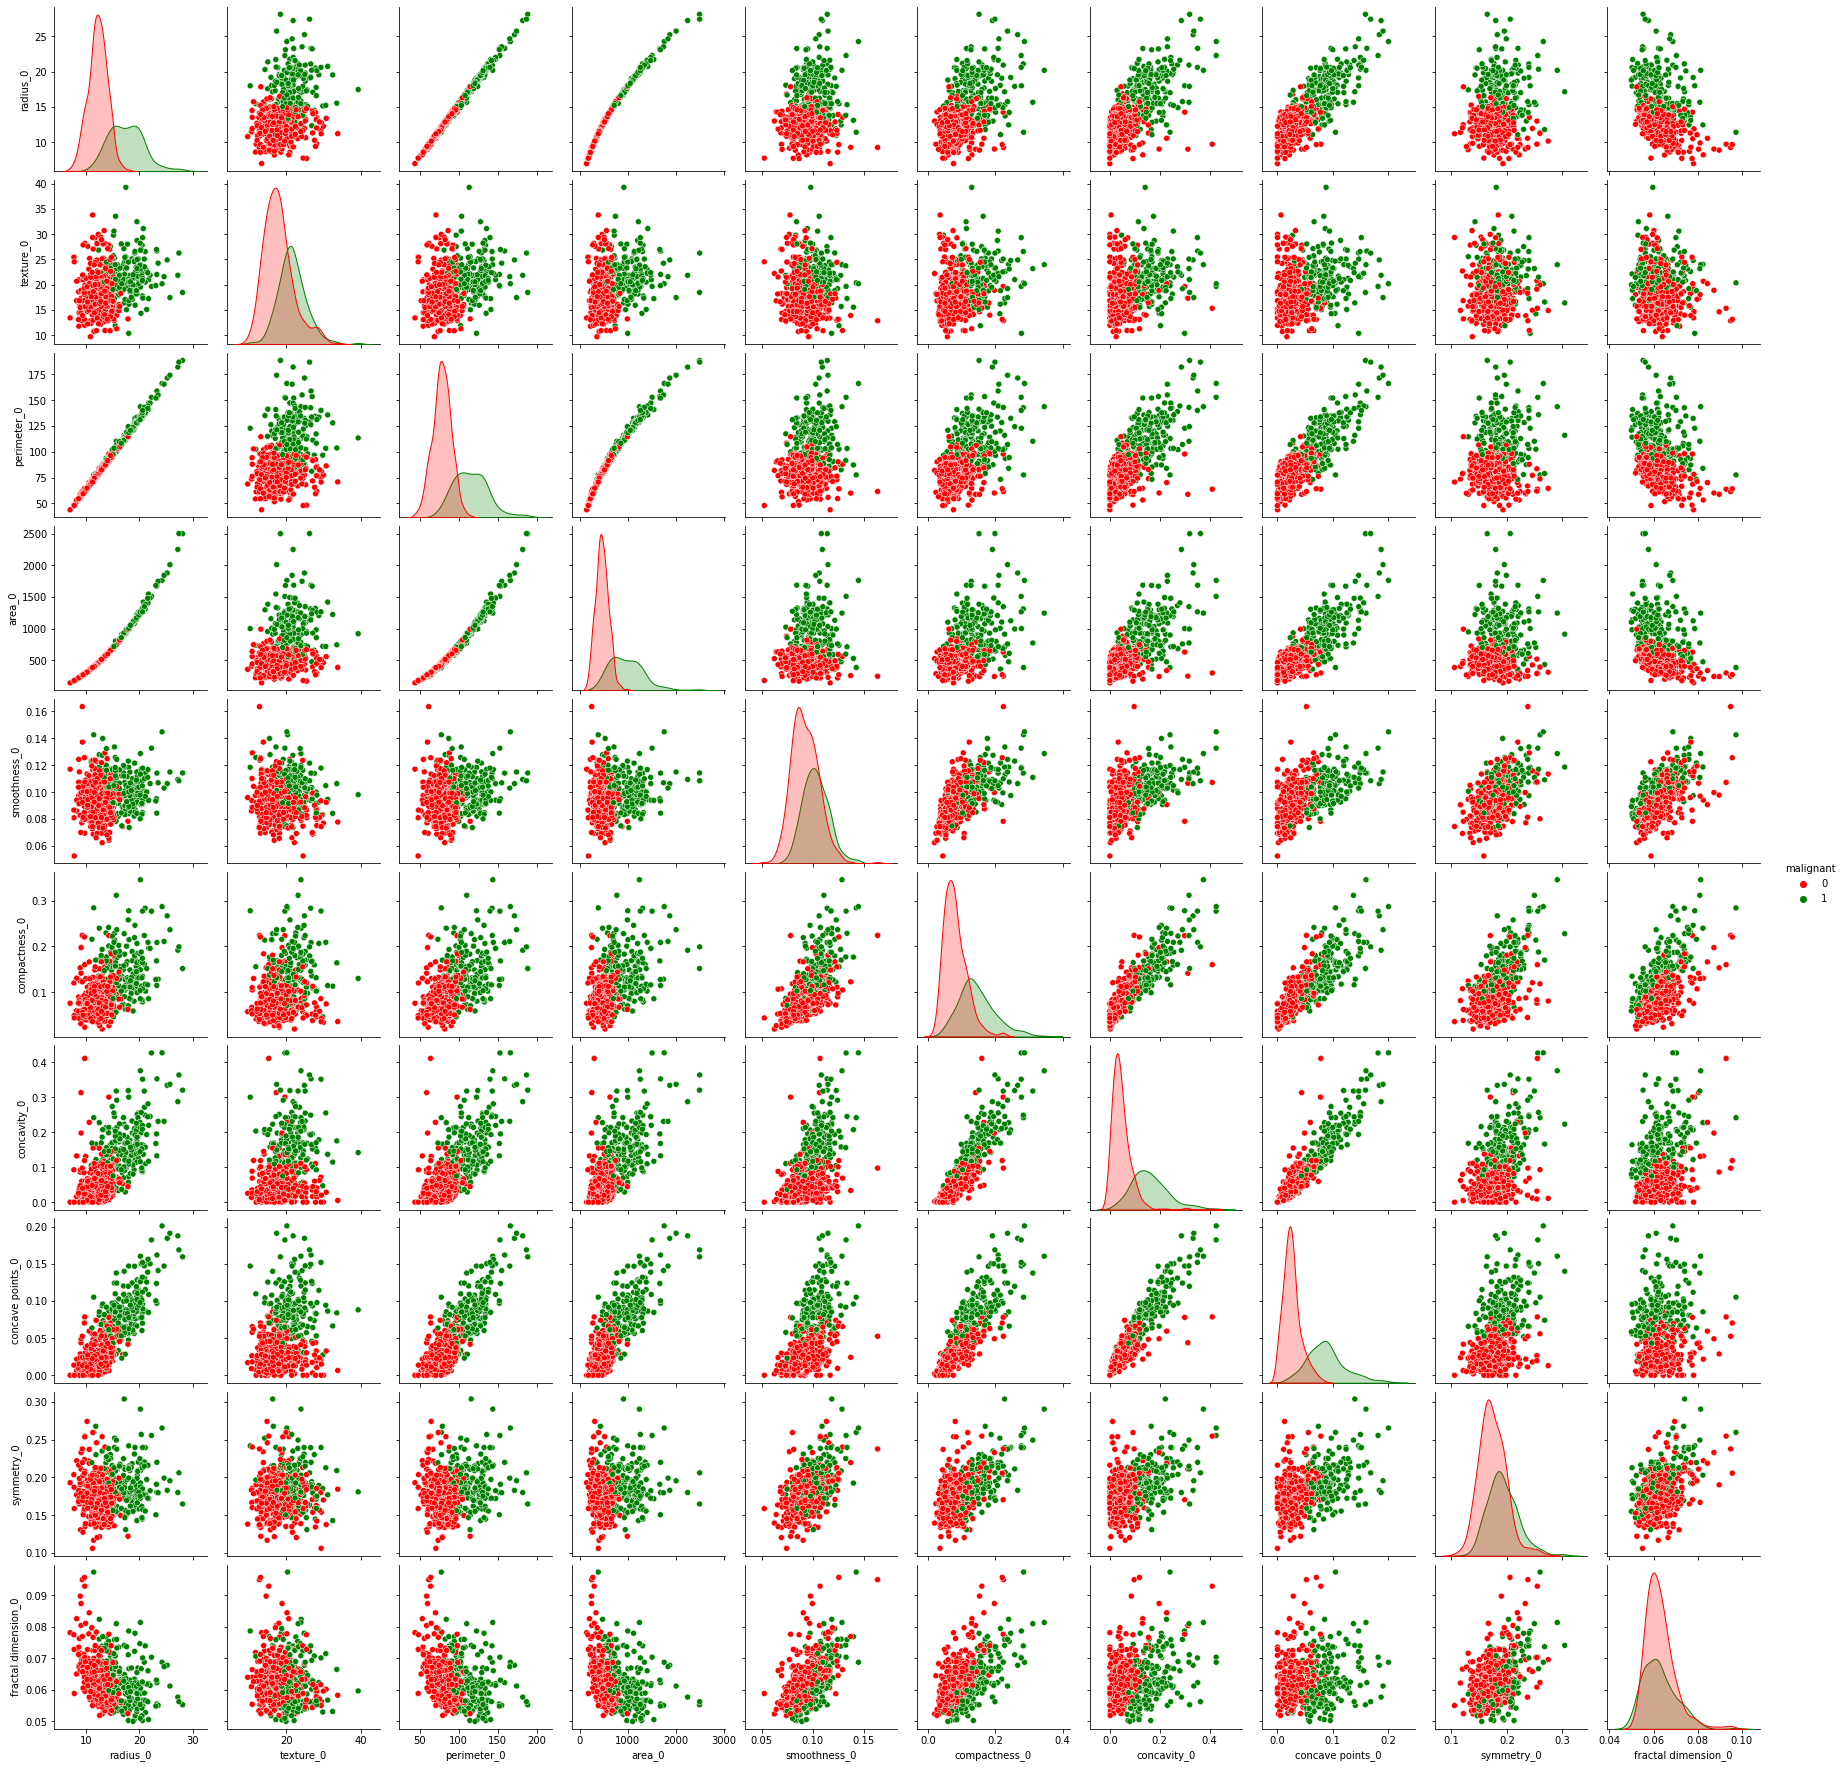

In [ ]:
sns.pairplot(df, palette=("r", "g"), hue="malignant")
sns.set(rc={'figure.figsize':(35,35)})

## Analyzing data and searching for patterns

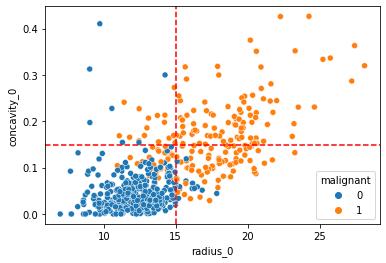

In [13]:
# decision threshold for rule based classifier
radius_plt = sns.scatterplot(data=df, x="radius_0", y="concavity_0", hue="malignant")
radius_plt.axvline(15, color="r", linestyle="--")
radius_plt.axhline(0.15, color="r", linestyle="--")
fig = radius_plt.get_figure()
fig.show()
fig.savefig('radius_concavity.png') 

Signs for malignancy:

If [cell size is abnormal] \
or [cell shape is abnormal] \
or [cell texture is abnormal] \
or [cell similarity/homogeneity is abnormal]

In [14]:
from sklearn.linear_model import LogisticRegression
X = data[['radius_0', 'concavity_0']]
Y = data['malignant']
clf = LogisticRegression(random_state=0).fit(X, Y)
#clf.predict(X)
clf.score(X, Y)

0.8875219683655536

## 1. Rule based classifier

In [15]:
def rule_based_clf(x: pd.DataFrame) -> int:
    """
    Look at radius and concavity as they the most strongly correlated features to the
    malignancy of a cell and see if they cross a certain threshold
    """
    if x["radius_0"] > 15:
        return 1
    if x["concavity_0"] > 0.15:
        return 1
    return 0

In [ ]:
def rule_based_score(X: pd.DataFrame, Y: pd.Series) -> float:
    results = np.zeros(X.shape[0])
    # prediction for every sample
    for idx, x in X.iterrows():
        pred = rule_based_clf(x)
        results[idx] = pred

    # calc accuracy by comparing against actual label
    cnt_correct, cnt_false = 0, 0
    for pred_y, true_y in zip(results, Y):
        if pred_y == true_y:
            cnt_correct += 1
        else:
            cnt_false += 1

    # metrics
    acc = cnt_correct / (cnt_correct + cnt_false)
    f1 = f1_score(Y, results)
    
    return acc, f1

In [ ]:
X, y = df.iloc[:,1:], df.iloc[:,0]
rule_acc, rule_f1 = rule_based_score(X, Y)
print("Accuracy: %.4f" %rule_acc)
print("F1-score: %.4f" %rule_f1)

Accuracy: 0.9069
F1-score: 0.8704


## 2. Random forest classifier

Consists of multiple decision trees

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X, y = df.iloc[:,1:], df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.30, random_state=42)
forest_clf = RandomForestClassifier(criterion='entropy', random_state=0)

model = forest_clf.fit(X_train, y_train)
forest_acc = forest_clf.score(X_test, y_test)

forest_y_pred = [forest_clf.predict([x]) for x in X_test]
forest_f1 = f1_score(y_test, forest_y_pred)

print(f"Accuracy: {forest_acc}")
print(f"F1-score: {forest_f1}")

Accuracy: 0.9590643274853801
F1-score: 0.9457364341085271


## 3 Classifier of own design

Trade off between interpretability and performance

Appraoch: **Decision tress**

In [ ]:
!pip install graphviz

     |████████████████████████████████| 46 kB 5.9 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from sklearn import tree

X, y = df.iloc[:,1:], df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)


In [ ]:
tree_acc = tree_clf.score(X_test, y_test)
tree_y_pred = [tree_clf.predict([x]) for x in X_test.to_numpy()]
tree_f1 = f1_score(y_test, tree_y_pred)

print(f"Accuracy: {tree_acc}")
print(f"F1-score: {tree_f1}")

Accuracy: 0.935672514619883
F1-score: 0.9147286821705426
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/pytho

In [ ]:
# visualize decision tree
import graphviz 
dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                        feature_names=X.columns,  
                        class_names=["Benign", "Malignant"],  
                        filled=True, rounded=True,  
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("decision_tree") 

'decision_tree.pdf'

## Applying PCA

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X)

pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_train_scaler)
X_pca

array([[ 0.82732684, -0.17267316],
       [ 1.15465367,  0.15465367],
       [ 1.98198051, -0.01801949],
       [-0.82732684,  0.17267316],
       [-1.15465367, -0.15465367],
       [-1.98198051,  0.01801949]])

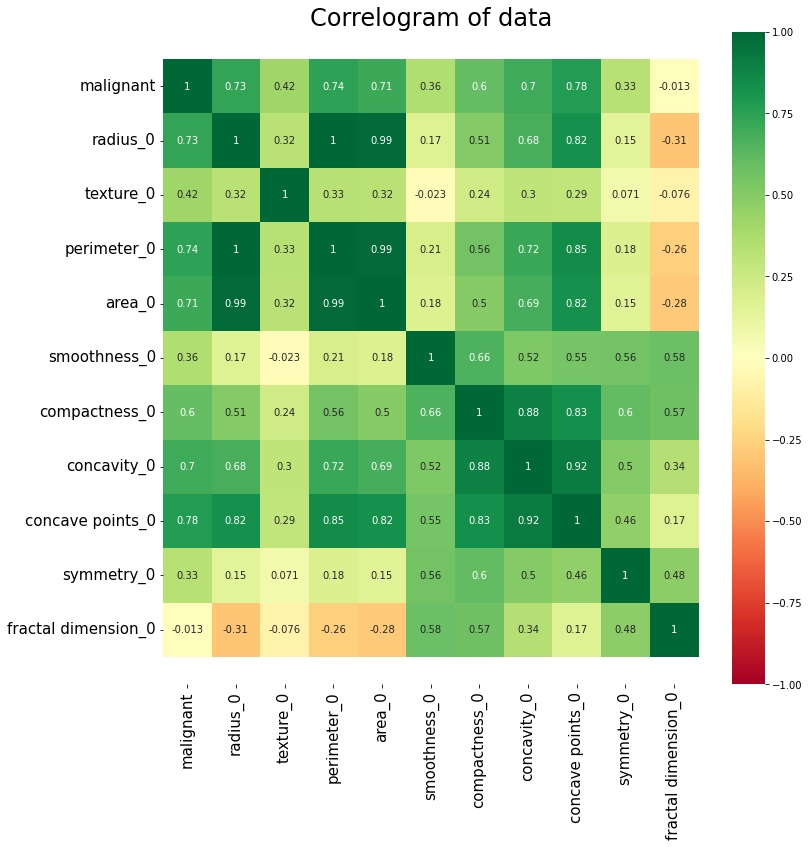

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2bb2a9e5-a05e-43bd-a036-c69cafbcfcf3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>